In [1]:
from pymatgen.ext.matproj import MPRester
from pymatgen.io.cif import CifParser
import matminer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

params = {'legend.fontsize': 14,
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize':12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)

%config InlineBackend.figure_format='retina'
%matplotlib Inline

https://github.com/materialsvirtuallab/nano281/blob/master/lectures/notebooks/Lecture%2003%20-%20Linear%20methods.ipynb
https://www.youtube.com/watch?v=jREekCKT47g&list=PLzGGfTpqE6yoct83uKY9xH6U7wOPTIMRQ&index=6

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/materialsvirtuallab/nano281/master/lectures/notebooks/element_data.csv",
                  index_col=0)

In [3]:
data.head()

,K,MP,BP,Z,X,r
Element,,,,,,
Ac,29.0,1323.00,3573.0,89,1.10,1.95
Ag,88.0,1234.93,2435.0,47,1.93,1.60
Al,83.0,933.47,2792.0,13,1.61,1.25
As,40.0,1090.00,887.0,33,2.18,1.15
Au,137.0,1337.33,3129.0,79,2.54,1.35


In [4]:
data["X^2"] = data["X"] ** 2
data["sqrt(X)"] = data["X"] ** 0.5
data["r^2"] = data["r"] ** 2
data["sqrt(r)"] = data["r"] ** 0.5
data.head()

,K,MP,BP,Z,X,r,X^2,sqrt(X),r^2,sqrt(r)
Element,,,,,,,,,,
Ac,29.0,1323.00,3573.0,89,1.10,1.95,1.2100,1.048809,3.8025,1.396424
Ag,88.0,1234.93,2435.0,47,1.93,1.60,3.7249,1.389244,2.5600,1.264911
Al,83.0,933.47,2792.0,13,1.61,1.25,2.5921,1.268858,1.5625,1.118034
As,40.0,1090.00,887.0,33,2.18,1.15,4.7524,1.476482,1.3225,1.072381
Au,137.0,1337.33,3129.0,79,2.54,1.35,6.4516,1.593738,1.8225,1.161895


In [5]:
features = [c for c in data.columns if c != "K"]
x = data[features]
y = data["K"] # bulk modulus

In [6]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

model = linear_model.LinearRegression()
model.fit(x, y)

print(model.coef_)
print(model.intercept_)

[ 4.24593389e-02  2.76250528e-02 -2.47598243e-01  3.92032157e+02
 -3.55139176e+02 -4.95560226e+01 -3.85039953e+02  5.40312522e+01
  4.99844526e+02]
-243.84408906776835


In [7]:
y_pred = model.predict(x)

mean_squared_error(y, y_pred)

3151.2551187309596

In [8]:
from sklearn.model_selection import cross_validate, KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
cross_validate(model, x, y, cv=kfold)

{'fit_time': array([0.00199437, 0.00199461, 0.00199437, 0.00099802, 0.00099778]),
 'score_time': array([0.00099683, 0.00099754, 0.0009973 , 0.00099683, 0.00099778]),
 'test_score': array([0.53602309, 0.6374767 , 0.13802533, 0.46002097, 0.34911668])}

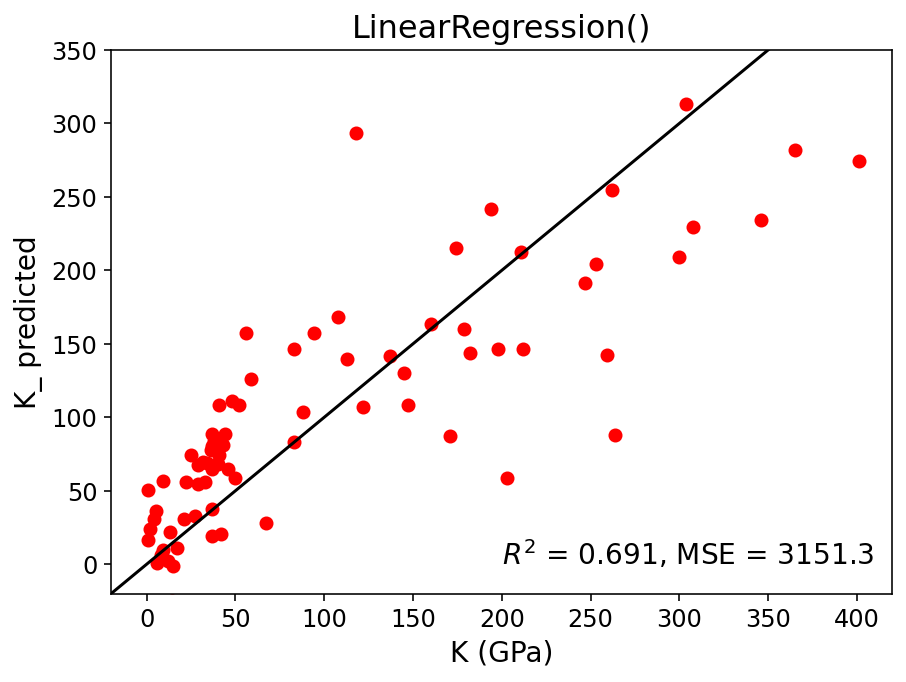

In [9]:
r2 = model.score(x, y)

plt.figure(figsize=(7, 5))
plt.plot(y, y_pred, 'ro')
plt.plot([-50, 550], [-50, 550], 'k-')
plt.title("{}".format(model))
plt.xlim(-20, 420)
plt.ylim(-20, 350)
plt.ylabel("K_ predicted")
plt.xlabel("K (GPa)")

plt.annotate(r"$R^2$ = %.3f, MSE = %.1f" % (r2, mean_squared_error(y, y_pred)), (200, 0), fontsize=14)
plt.show();

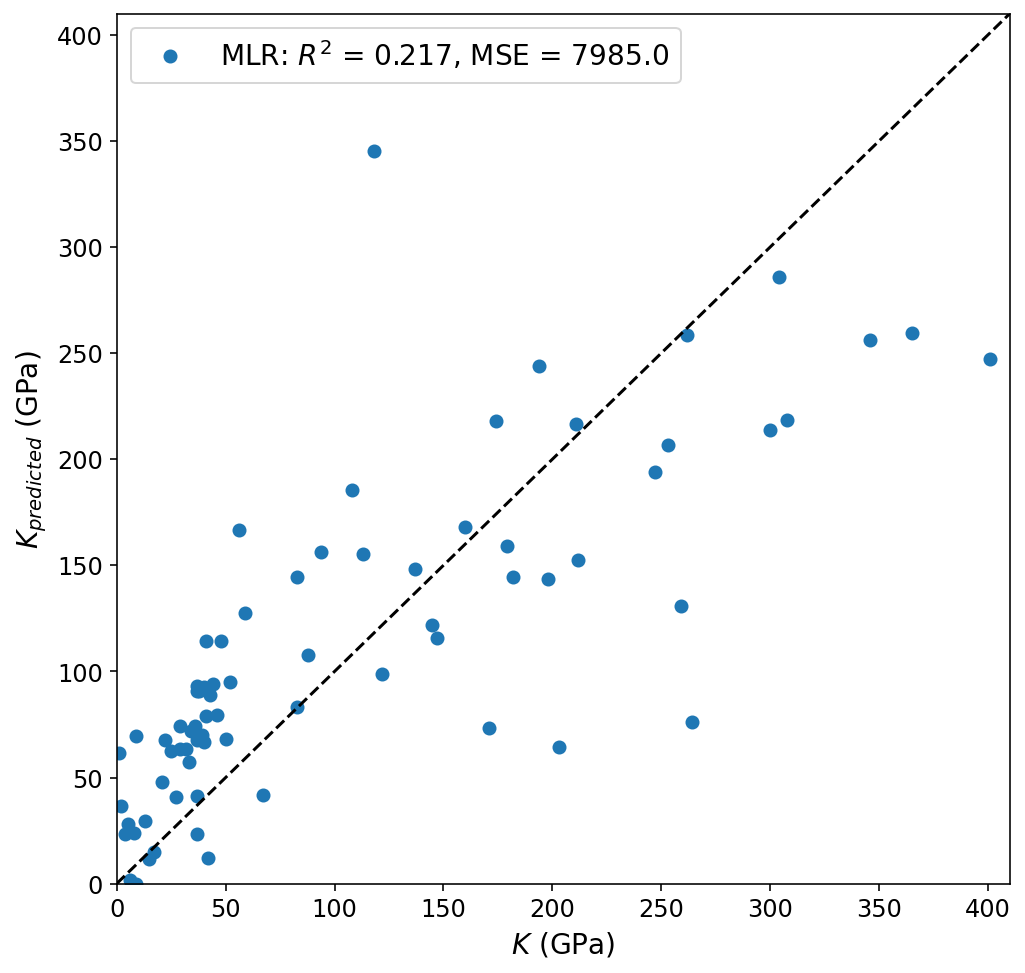

In [10]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mlr = linear_model.LinearRegression()
yhat_mlr = cross_val_predict(mlr, x, y, cv=kfold)
r2_mlr = r2_score(y, yhat_mlr)
mse_mlr = mean_squared_error(y, yhat_mlr)
label_mlr = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr, mse_mlr)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.ylabel(r"$K_{predicted}$ (GPa)")
plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

In [11]:
# grid = sns.pairplot(data[features])

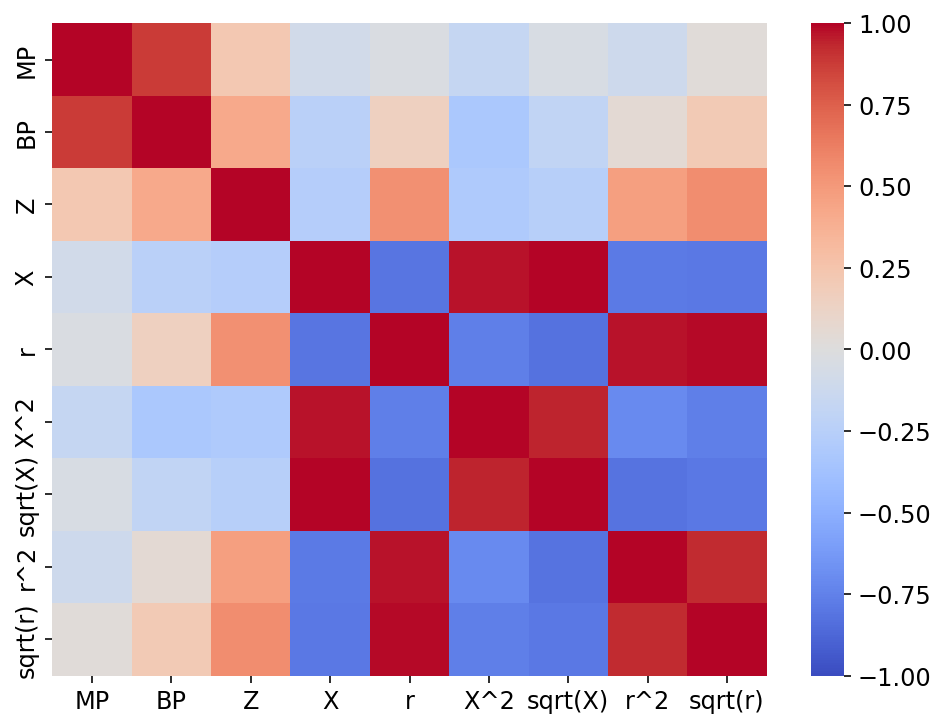

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(x.corr(), cmap="coolwarm", vmin=-1, vmax=1, ax=ax);

In [13]:
from sklearn.feature_selection import SelectKBest, f_regression

def identify_columns(x_new, nrows=10):
    columns = x.columns
    xvalues = x.values
    dist = np.linalg.norm(xvalues[:nrows, :, None] - x_new[:nrows, None, :], axis=0)
    return columns[np.argmin(dist, axis=0)].values
    
sel = SelectKBest(f_regression, k=3)
x_new = sel.fit_transform(x, y)
print(f"Selected features {identify_columns(x_new)}")

Selected features ['MP' 'BP' 'r^2']


In [14]:
s = ', '.join(['%s: %.3e' % (i, j) for i, j in zip(x.columns, sel.pvalues_)])
print("The p values for the variables are " + s)

The p values for the variables are MP: 5.017e-17, BP: 3.285e-14, Z: 1.382e-01, X: 1.760e-01, r: 9.118e-02, X^2: 6.985e-01, sqrt(X): 6.706e-02, r^2: 1.346e-02, sqrt(r): 2.524e-01


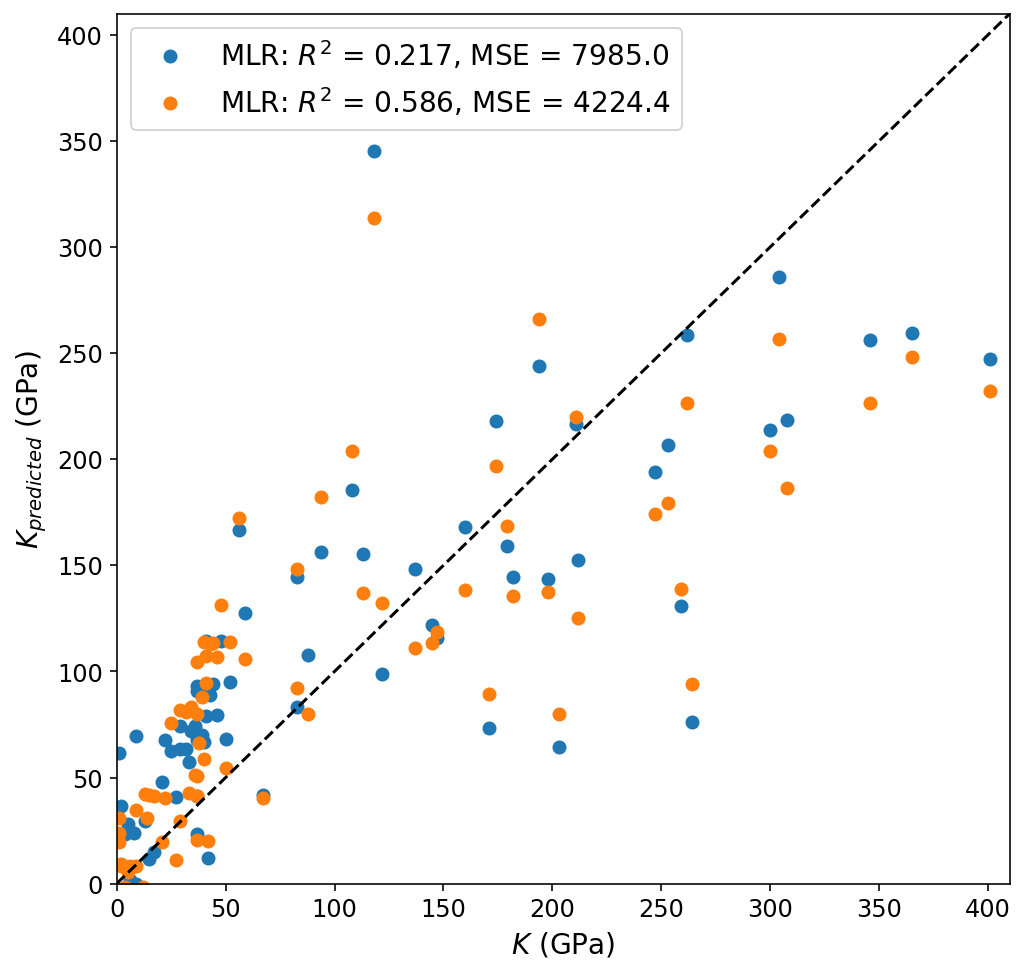

In [15]:
mlr_best = linear_model.LinearRegression()
yhat_mlr_best = cross_val_predict(mlr_best, x_new, y, cv=kfold)
r2_mlr_best = r2_score(y, yhat_mlr_best)
mse_mlr_best = mean_squared_error(y, yhat_mlr_best)
label_mlr_best = "MLR: $R^2$ = %.3f, MSE = %.1f" % (r2_mlr_best, mse_mlr_best)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.plot(y, yhat_mlr_best, 'o', label=label_mlr_best)
l = plt.ylabel(r"$K_{predicted}$ (GPa)")
l = plt.xlabel(r"$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

### Ridge regression

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x)
means_ = scaler.mean_
stds_ = scaler.scale_
z = scaler.transform(x)

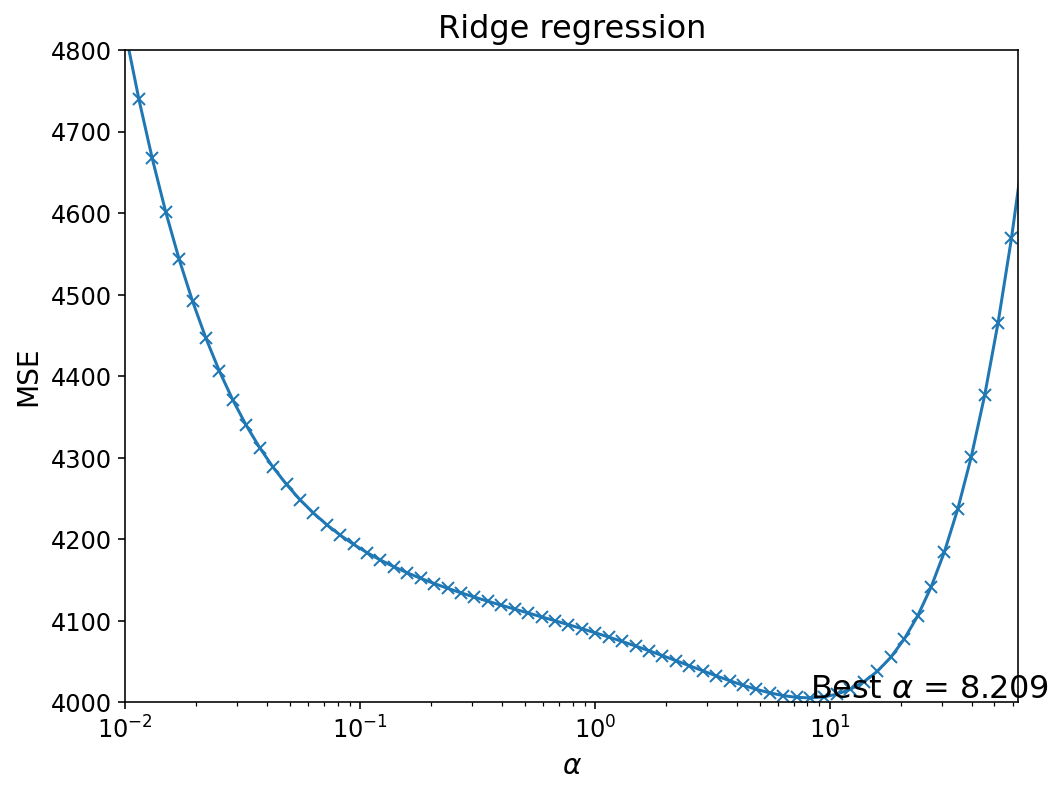

In [17]:
from sklearn.model_selection import cross_validate, KFold

cv_results = []
coeffs = []
alphas = np.logspace(-2, 2, 71)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(z, y)
    scores = cross_validate(ridge, z, y, cv=kfold, scoring="neg_mean_squared_error")
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(ridge.coef_))

cv_results = pd.DataFrame(cv_results, columns=["alpha", "score"] + features)
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(cv_results["alpha"], cv_results["score"], '-x')
plt.xlim([1e-2, 10**1.8])
plt.ylim((4000, 4800))
plt.xscale(r'log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'MSE')
plt.title(r'Ridge regression')
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(r"Best $\alpha$ = %.3f" % best_alpha, (best_alpha, cv_results["score"].min()), fontsize=16);

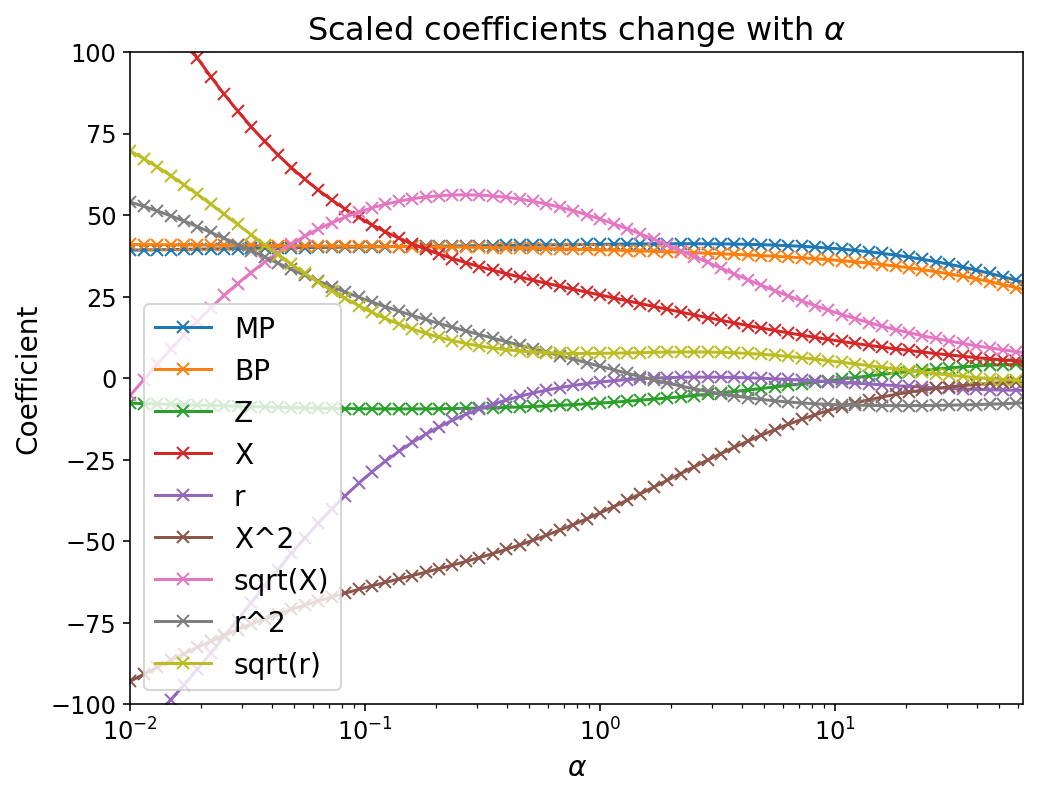

In [18]:
f, ax = plt.subplots(figsize=(8, 6))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], '-x', label=f)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Coefficient')
    plt.title(r'Scaled coefficients change with $\alpha$')
plt.legend()
plt.xlim([1e-2, 10**1.8])
plt.ylim([-100, 100]);

In [31]:
reg = linear_model.Ridge(alpha=best_alpha, max_iter=10000)
reg.fit(z, y)

real_coef = reg.coef_  / stds_   # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = ["%.2e %s" % (v, f) for v, f in zip(real_coef, features)]
print("K = %.1f + %s" % (real_interp, " + ".join(equation)))

K = -279.9 + 4.54e-02 MP + 2.53e-02 BP + -1.71e-01 Z + 2.78e+01 X + 7.65e-01 r + -8.64e+00 X^2 + 1.43e+02 sqrt(X) + -4.29e+00 r^2 + 4.50e+01 sqrt(r)


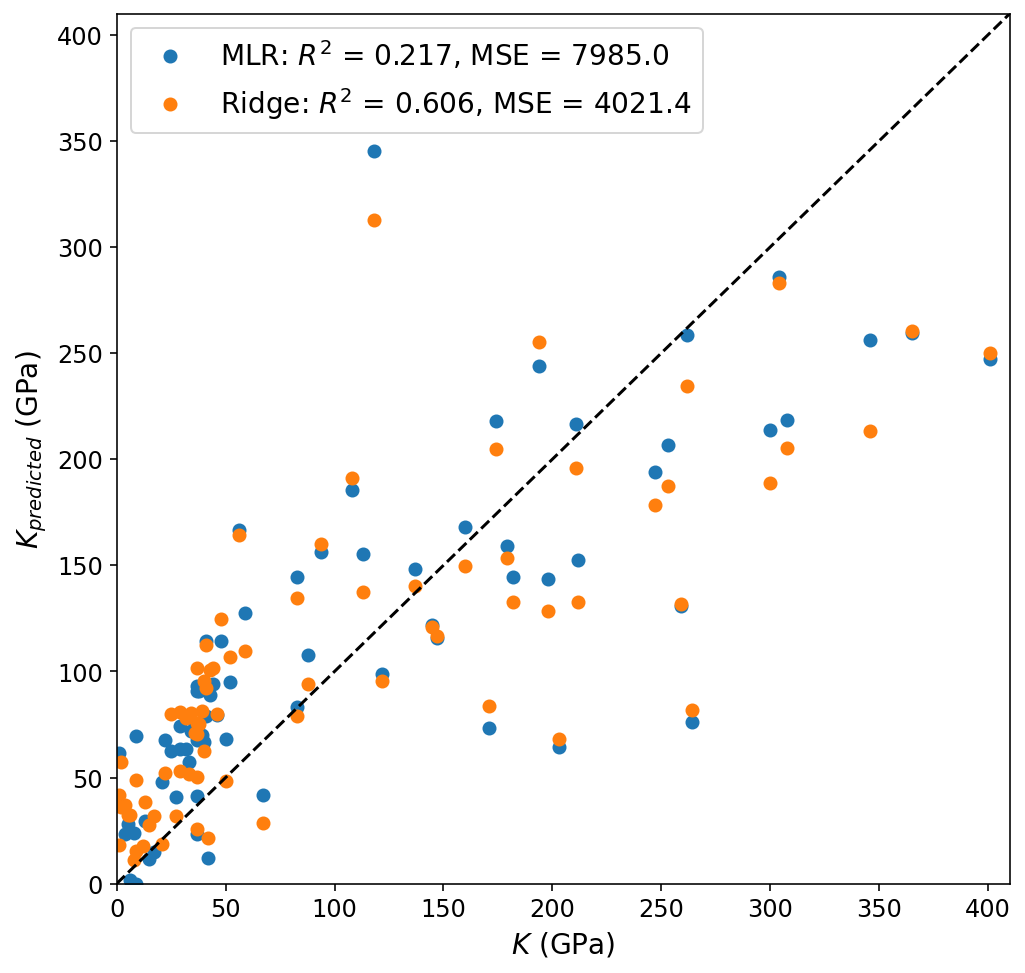

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

ridge = linear_model.Ridge(alpha=best_alpha, max_iter=10000)
yhat_ridge = cross_val_predict(ridge, z, y, cv=kfold)
r2_ridge = r2_score(y, yhat_ridge)
mse_ridge = mean_squared_error(y, yhat_ridge)
label_ridge = "Ridge: $R^2$ = %.3f, MSE = %.1f" % (r2_ridge, mse_ridge)

f, ax = plt.subplots(figsize=(8, 8))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.plot(y, yhat_ridge, 'o', label=label_ridge)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

### LASSO

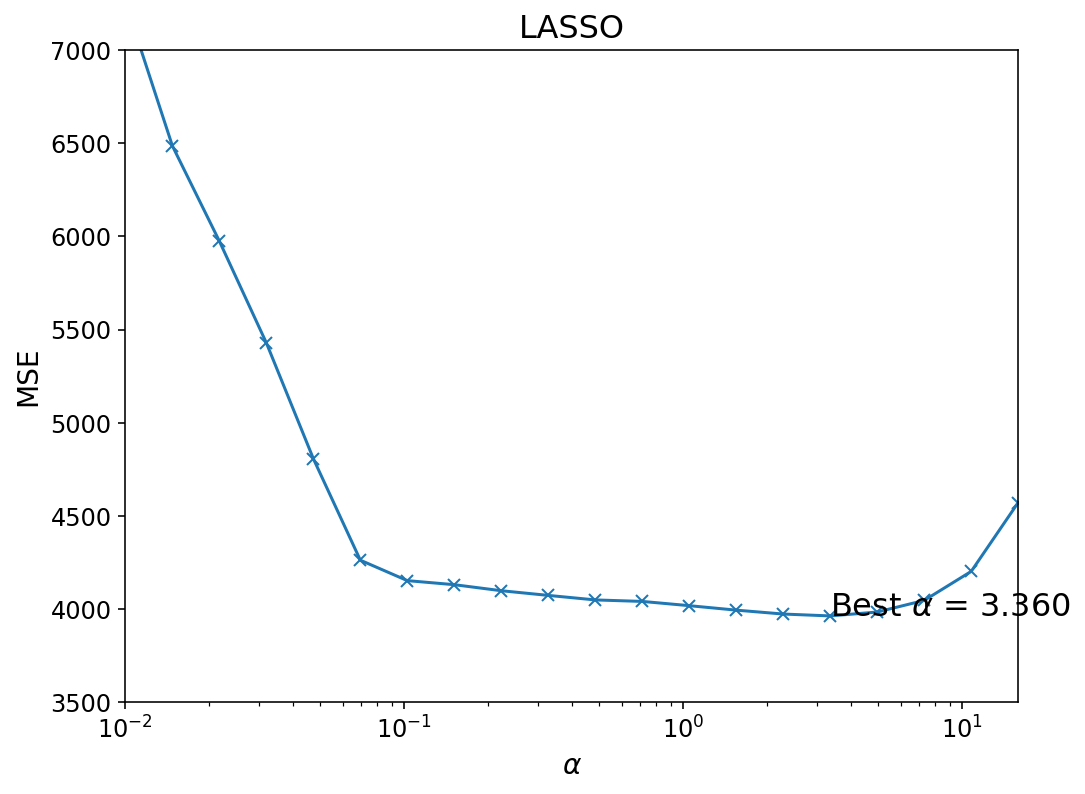

In [22]:
alphas = np.logspace(-2, 1.2, 20)
cv_results = []
coeffs = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, max_iter=100000)
    lasso.fit(z, y)
    scores = cross_validate(lasso, z, y, cv=kfold, scoring='neg_mean_squared_error')
    cv_results.append([alpha, -np.mean(scores["test_score"])] + list(lasso.coef_))

cv_results = pd.DataFrame(cv_results, columns=["alpha", "score"] + features)
f, ax = plt.subplots(figsize=(8, 6))
plt.plot(cv_results["alpha"], cv_results["score"], '-x')
plt.xlim([1e-2, 10**1.2])
plt.ylim((3500, 7000))
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title('LASSO')
best_alpha = cv_results["alpha"][cv_results["score"].idxmin()]
plt.annotate(r"Best $\alpha$ = %.3f" % best_alpha, 
             (best_alpha, cv_results["score"].min()), fontsize=16);

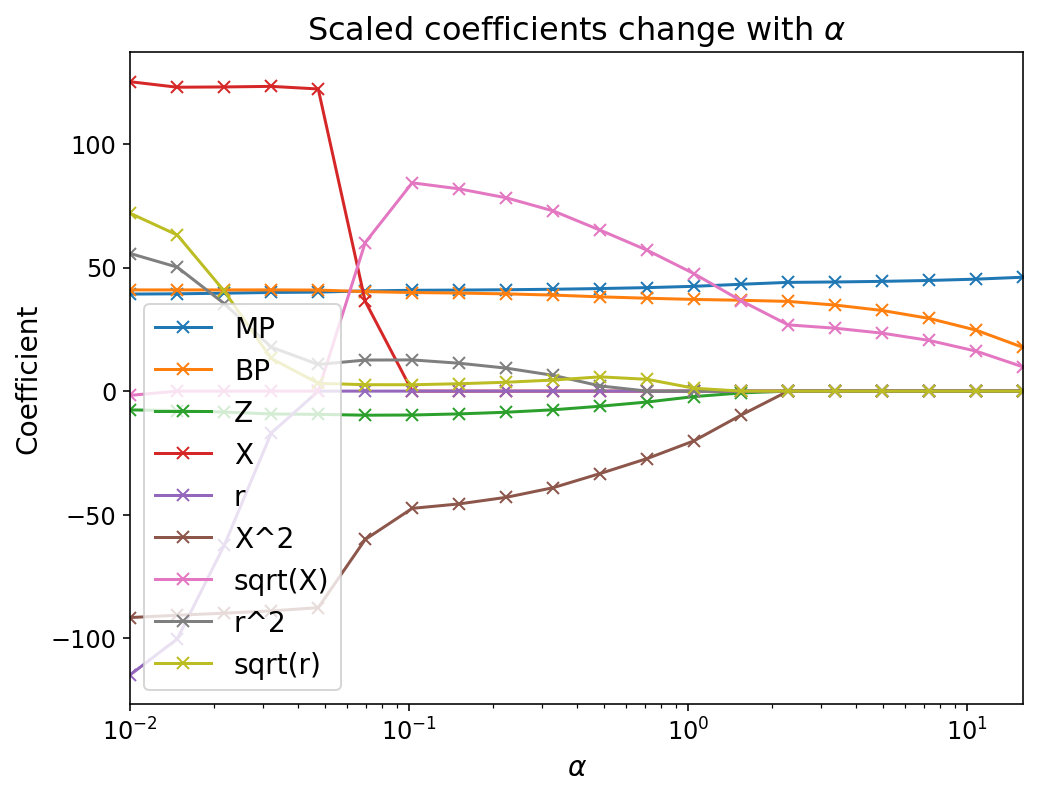

In [24]:
f, ax = plt.subplots(figsize=(8, 6))
for f in features:
    plt.plot(cv_results["alpha"], cv_results[f], '-x', label=f)
    plt.xscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Coefficient')
    plt.title(r'Scaled coefficients change with $\alpha$')
plt.legend()
plt.xlim([1e-2, 10**1.2]);

We will now retrieve the final equation, ignoring the coefficients that are zero. We note that the atomic number Z no longer appears in the equation. This is somewhat in line with intuition since we do not expect atomic number to have a significant relationship with the bulk modulus. As you may recall, the electronegativity and atomic radius are inversely correlated with each other. So we would expect only one of these parameters to be needed to describe the bulk modulus. Furthermore, it seems that the bulk modulus should be related to sqrt(X) and not X.

In [25]:
reg = linear_model.Lasso(alpha=best_alpha, max_iter=10000)
reg.fit(z, y)

real_coef = reg.coef_  / stds_   # convert back to unnormalized inputs
real_interp = reg.intercept_ - means_.dot(real_coef)  # convert back to unnormalized inputs

equation = ["%.2e %s" % (v, f) for v, f in zip(real_coef, features) if abs(v) > 1e-4]
print("K = %.1f + %s" % (real_interp, " + ".join(equation)))

K = -178.1 + 4.87e-02 MP + 2.31e-02 BP + 1.09e+02 sqrt(X)


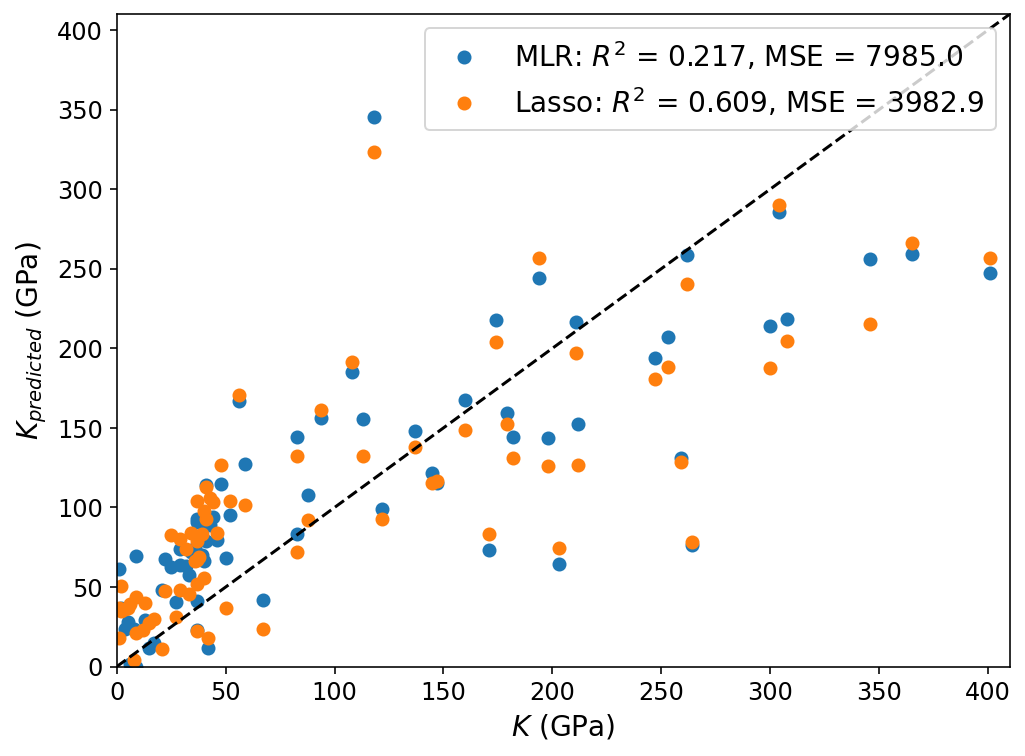

In [26]:
lasso = linear_model.Lasso(alpha=best_alpha, max_iter=10000)
yhat_lasso = cross_val_predict(lasso, z, y, cv=kfold)
r2_lasso = r2_score(y, yhat_lasso)
mse_lasso = mean_squared_error(y, yhat_lasso)
label_lasso = "Lasso: $R^2$ = %.3f, MSE = %.1f" % (r2_lasso, mse_lasso)

f, ax = plt.subplots(figsize=(8, 6))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.plot(y, yhat_lasso, 'o', label=label_lasso)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');

 Diferrences btw Ridge and LASSO <br>
 1) In Ridge, when $\alpha$ increases, features will never reach zero, while they do in LASSO. <br>
 2) Ridge: proportinal shrinkage <br>
 3) LASSO: soft thresholding <br>

## Partial Least Squares

aka Elastic net: a combination of Ridge and LASSO

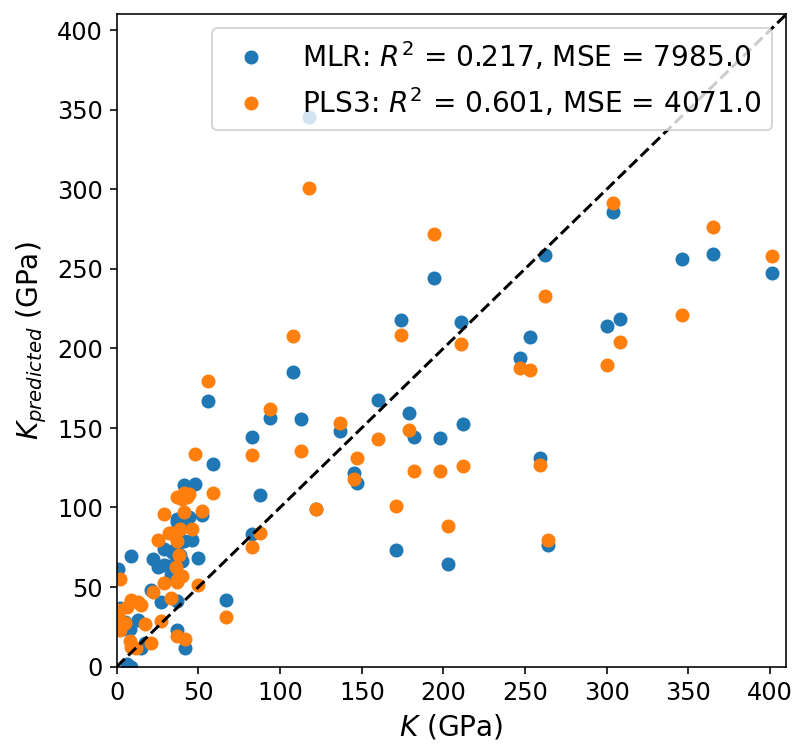

In [29]:
from sklearn.cross_decomposition import PLSRegression
cv_results = []
coeffs = []
pls = PLSRegression(n_components=2)
pls.fit(x, y)
yhat_pls = cross_val_predict(pls, x, y, cv=kfold)
r2_pls = r2_score(y, yhat_pls)
mse_pls = mean_squared_error(y, yhat_pls)
label_pls = "PLS3: $R^2$ = %.3f, MSE = %.1f" % (r2_pls, mse_pls)

f, ax = plt.subplots(figsize=(6, 6))
plt.plot(y, yhat_mlr, 'o', label=label_mlr)
plt.plot(y, yhat_pls, 'o', label=label_pls)
l = plt.ylabel("$K_{predicted}$ (GPa)")
l = plt.xlabel("$K$ (GPa)")
plt.legend()
plt.xlim([0, 410])
plt.ylim([0, 410])
plt.plot([0, 410], [0, 410], 'k--');